In [1]:
# Single input, Multiple output generator
# This example use one input, three output

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [3]:
# Generating data and labels
def dummy_function(x):
    a = 0.4 * np.sin(0.3 * x) * np.abs(x)
    b = np.log1p(np.abs(x)) * np.cos(x)
    c = np.exp(-x**2 / 100) * np.cos(x)
    return [a, b, c]
x = np.arange(-10, 10, 0.01)
y = np.array([dummy_function(xi) for xi in x])

# Create train, validation and test set IDs
train_idx, predict_idx = train_test_split(np.arange(x.shape[0]), random_state=2020, test_size=0.20)
train_idx, val_idx = train_test_split(train_idx, random_state=2020, test_size=0.20)

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode, id_list, x, y, xdim, ydim,
                 sample_weights=None, batch_size=8, random_state=2020, shuffle=False):
        self.mode = mode # fit / val / predict
        self.id_list = id_list # data id: if data must be loaded it is easier to work with ids
        self.x = x # data
        self.y = y # labels
        self.xdim = xdim # sample dim = (2,2) if [[1,0], [2, 2]]
        self.ydim = ydim # list of label dimensions
        self.sample_weights = sample_weights # ignored if None
        self.batch_size = batch_size
        self.random_state = random_state
        self.shuffle = shuffle
        
        # Shuffle ID list before first epoch if shuffling enabled
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find IDs of current batch
        id_list_batch = [self.id_list[k] for k in indexes]
        
        # Ceate data
        batch_x = self.__generate_X(id_list_batch)
        
        if self.mode == 'fit' or self.mode == 'val':
            batch_y = self.__generate_y(id_list_batch)
            if self.sample_weights != None:
                batch_sample_weight = self.__generate_sample_weight(id_list_batch)
                return batch_x, batch_y, batch_sample_weight
            return batch_x, batch_y
        
        elif self.mode == 'predict':
            return batch_x
        
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, id_list_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size , *self.xdim))
        
        # Generate data
        for i, ID in enumerate(id_list_batch):
            # Store samples & rescale to 0..1
            if self.mode == 'fit':
                temp = self.x[ID, ...]
                
                #
                # ON THE FLY AUGMENTATION SHOULD BE HERE
                # Current code is not suitable for multiplying sample with augmentation
                # for example: noise, random mirroring, etc.
                #
                
            if self.mode == 'val' or self.mode == 'predict':
                temp = self.x[ID, ...]
                
            #
            # ON THE FLY NORMALIZATION SHOULD BE HERE
            # for example: temp = temp / 255.
            #
            
            # Copy finished sample to current batch
            X[i] = temp
            
        return X
    
    def __generate_y(self, list_IDs_batch):
        y = []
        for dim in self.ydim:
            y.append(np.empty((self.batch_size, *dim)))
            
        for i, ID in enumerate(list_IDs_batch):
            # Store samples
            y[0][i] = self.y[ID][0, ...]
            y[1][i] = self.y[ID][1, ...]
            y[2][i] = self.y[ID][2, ...]
            
        return y
    
    def __generate_sample_weight(self, id_list_batch):
        # TODO: implement
        return sample_weight

In [5]:
def create_model():   
    input0 = Input(shape=(1))
    
    x0 = Dense(16, activation='relu') (input0)
    
    x1 = Dense(8, activation='relu') (x0)
    
    output0 = Dense(1, name='function_a')(x1)
    output1 = Dense(1, name='function_b')(x1)
    output2 = Dense(1, name='function_c')(x1)

    model = Model(input0, [output0, output1, output2])

    losses = {'function_a': 'mse', 'function_b': 'mse', 'function_c': 'mse'}
    loss_weights = {'function_a': 1.0, 'function_b': 1.0, 'function_c': 1.0}
    model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights)
    
    return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           32          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            136         dense[0][0]                      
__________________________________________________________________________________________________
function_a (Dense)              (None, 1)            9           dense_1[0][0]                    
______________________________________________________________________________________________

In [6]:
# Set up generators for training
BATCH_SIZE = 8
train_generator = DataGenerator(mode='fit',
                                id_list=train_idx,
                                x=x,
                                y=y,
                                xdim=x[0].shape,
                                ydim=[y[0][0].shape, y[0][1].shape, y[0][2].shape],
                                batch_size=BATCH_SIZE,
                                shuffle=True)
val_generator = DataGenerator(mode='val',
                              id_list=val_idx,
                              x=x,
                              y=y,
                              xdim=x[0].shape,
                              ydim=[y[0][0].shape, y[0][1].shape, y[0][2].shape],
                              batch_size=BATCH_SIZE)

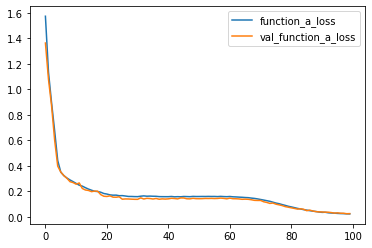

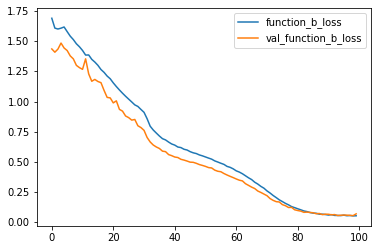

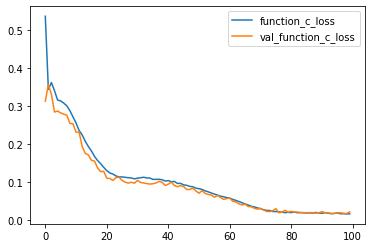

In [7]:
# Training NN
history = model.fit(x=train_generator,
                    validation_data=val_generator,
                    epochs=100,
                    verbose=0)

# Plot the training and validation loss for each epoch
history_df = pd.DataFrame(history.history)
history_df[['function_a_loss', 'val_function_a_loss']].plot()
history_df[['function_b_loss', 'val_function_b_loss']].plot()
history_df[['function_c_loss', 'val_function_c_loss']].plot()

In [8]:
# Prediction
predict_generator = DataGenerator(mode='predict',
                                  id_list=predict_idx,
                                  x=x,
                                  y=y,
                                  xdim=x[0].shape,
                                  ydim=[y[0][0].shape, y[0][1].shape, y[0][2].shape],
                                  batch_size=BATCH_SIZE)

predictions = model.predict(predict_generator)

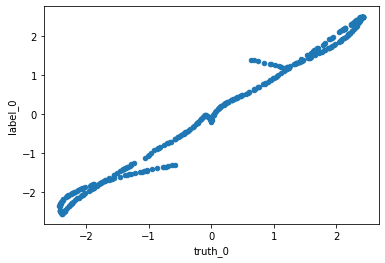

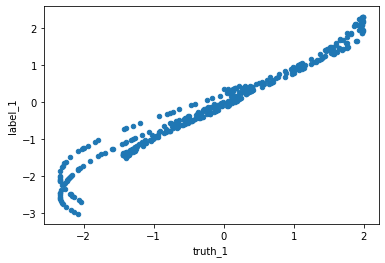

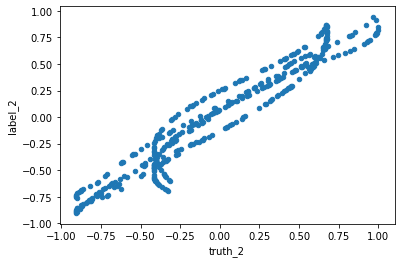

In [9]:
# Visualize prediction quality
pred_df = pd.DataFrame()
pred_df['truth_0'] = [y[idx][0] for idx in predict_idx]
pred_df['truth_1'] = [y[idx][1] for idx in predict_idx]
pred_df['truth_2'] = [y[idx][2] for idx in predict_idx]
pred_df['label_0'] = predictions[0].reshape(-1)
pred_df['label_1'] = predictions[1].reshape(-1)
pred_df['label_2'] = predictions[2].reshape(-1)

pred_df.plot.scatter(x='truth_0', y='label_0')
pred_df.plot.scatter(x='truth_1', y='label_1')
pred_df.plot.scatter(x='truth_2', y='label_2')